## Student Information

In [1]:
# Student Name: Daniel Nemirovskiy, Nathan Seaney
# Student ID: DEN200001, 
# Course Name: CS 4375-002

## Importing Necessary Libraries

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
import copy
import random
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict

## Setting GPU

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## Creating Directories for Results

In [4]:
os.makedirs('./results', exist_ok=True)
os.makedirs('./results/runs', exist_ok=True)

## Obtaining the Datasets

In [5]:
def get_datasets(dataset_name, batch_size=32, num_workers=2):
    """
    Load and preprocess datasets. Split into train and test sets
    """
    # define transformations with reduced augmentation
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    # Load dataset
    if dataset_name.lower() == 'cifar10':
        train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                                    download=True, transform=transform_train)
        test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                                   download=True, transform=transform_test)
        dataset_info = {
            'name': 'CIFAR-10',
            'num_classes': 10,
            'classes': ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'),
            'input_channels': 3,
            'input_shape': (32, 32)
        }
        
    elif dataset_name.lower() == 'svhn':
        train_dataset = torchvision.datasets.SVHN(root='./data', split='train',
                                                download=True, transform=transform_train)
        test_dataset = torchvision.datasets.SVHN(root='./data', split='test',
                                               download=True, transform=transform_test)
        dataset_info = {
            'name': 'SVHN',
            'num_classes': 10,
            'classes': tuple(str(i) for i in range(10)),  # Digits 0-9
            'input_channels': 3,
            'input_shape': (32, 32)
        }
    else:
        raise ValueError(f"Dataset {dataset_name} not supported. Use 'cifar10' or 'svhn'.")
    
    # Use all training data without a validation split
    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                             shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                           shuffle=False, num_workers=num_workers)
    
    print(f"Dataset: {dataset_info['name']}")
    print(f"Number of training samples: {len(train_dataset)}")
    print(f"Number of testing samples: {len(test_dataset)}")
    
    return train_loader, test_loader, dataset_info


## Visualizing the Data Samples

In [6]:
def visualize_dataset_samples(loader, classes, num_samples=5):
    """
    Visualize samples from a dataset.
    """
    samples, labels = next(iter(loader))
    
    # Move samples to CPU and convert to numpy
    samples = samples.cpu().numpy()
    
    # Unnormalize images
    samples = samples / 2 + 0.5
    
    # Plot samples
    plt.figure(figsize=(15, 10))
    for i in range(min(num_samples, len(samples))):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(np.transpose(samples[i], (1, 2, 0)))
        plt.title(classes[labels[i].item() if isinstance(labels[i], torch.Tensor) else labels[i]])
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    print(f"Showing {num_samples} sample images from dataset")

## Implementing the LeNet Model

In [7]:
class LeNet(nn.Module):
    """
    LeNet-5 CNN architecture
    """
    def __init__(self, num_classes=10, input_channels=3):
        super(LeNet, self).__init__()
        # Layer 1: Convolutional layer with 6 filters of size 5x5, followed by ReLU and 2x2 max pooling
        self.conv1 = nn.Conv2d(input_channels, 6, kernel_size=5, padding=2)  # Padding=2 to preserve spatial dimensions
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Layer 2: Convolutional layer with 16 filters of size 5x5, followed by ReLU and 2x2 max pooling
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Calculate size after convolutions and pooling for a 32x32 input image
        # After conv1 + pool1: 32x32 -> 16x16
        # After conv2 + pool2: 16x16 -> 6x6 (due to no padding in conv2)
        # Fully connected layers
        self.fc1 = nn.Linear(16 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)
        
    def forward(self, x):
        # First convolutional block
        x = self.pool1(F.relu(self.conv1(x)))
        
        # Second convolutional block
        x = self.pool2(F.relu(self.conv2(x)))
        
        # Flatten the tensor
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

# Test the model with a random input tensor
def test_lenet():
    model = LeNet()
    sample_input = torch.randn(1, 3, 32, 32)  # Batch size 1, 3 channels, 32x32 image
    output = model(sample_input)
    print(f"LeNet Test:")
    print(f"  Input shape: {sample_input.shape}")
    print(f"  Output shape: {output.shape}")
    print(f"  Number of parameters: {sum(p.numel() for p in model.parameters())}")

## Implementing the ResNet-18 Model

In [8]:
class BasicBlock(nn.Module):
    """
    Basic block for ResNet-18 and ResNet-34
    """
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        # Second convolutional layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Shortcut connection to match dimensions
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        # Main path
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        
        # Add shortcut connection
        out += self.shortcut(x)
        out = F.relu(out)
        
        return out

class ResNet18(nn.Module):
    """
    ResNet-18 implementation
    """
    def __init__(self, num_classes=10, input_channels=3):
        super(ResNet18, self).__init__()
        
        # Initial convolutional layer
        self.in_channels = 64
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        
        # Four layers of the network, each with multiple residual blocks
        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)
        
        # Global average pooling and fully connected layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * BasicBlock.expansion, num_classes)
    
    def _make_layer(self, block, out_channels, num_blocks, stride):
        """
        Create a layer of residual blocks
        """
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        
        return nn.Sequential(*layers)
    
    def forward(self, x):
        # Initial convolution
        out = F.relu(self.bn1(self.conv1(x)))
        
        # ResNet layers
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        # Global average pooling
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        
        # Fully connected layer
        out = self.fc(out)
        
        return out

# Test the model with a random input tensor
def test_resnet18():
    model = ResNet18()
    sample_input = torch.randn(1, 3, 32, 32)  # Batch size 1, 3 channels, 32x32 image
    output = model(sample_input)
    print(f"ResNet-18 Test:")
    print(f"  Input shape: {sample_input.shape}")
    print(f"  Output shape: {output.shape}")
    print(f"  Number of parameters: {sum(p.numel() for p in model.parameters())}")

## Implementing our Custom FCNN

In [9]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomCNN, self).init()

        # Initial Downsampling using strided convolution instead of max pooling
        self.conv1 = nn.Conv2d(3, 24, kernel_size=7, stride=2, padding=3)
        self.act1 = nn.GELU()  # Non-standard activation for diversity

        # Depthwise separable convolution block (more efficient & less common)
        self.dwconv2 = nn.Conv2d(24, 24, kernel_size=3, stride=1, padding=1, groups=24)
        self.pwconv2 = nn.Conv2d(24, 48, kernel_size=1)
        self.act2 = nn.GELU()

        # Dilated convolution block (to capture context without downsampling)
        self.dilated_conv = nn.Conv2d(48, 64, kernel_size=3, padding=2, dilation=2)
        self.bn3 = nn.BatchNorm2d(64)
        self.act3 = nn.SiLU()  # Swish-like activation

        # Global average pooling instead of flatten + dense
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Classifier
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.act1(self.conv1(x))

        x = self.act2(self.pwconv2(self.dwconv2(x)))

        x = self.act3(self.bn3(self.dilated_conv(x)))

        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)

        x = self.dropout(x)
        x = self.fc(x)

        return x

# Test the model with a random input tensor
def test_customcnn():
    model = CustomCNN(
        filters=(16, 32, 64), 
        kernel_sizes=(3, 3, 3), 
        fc_sizes=(128,),
        dropout_rate=0.2,
        use_batch_norm=True
    )
    sample_input = torch.randn(1, 3, 32, 32)  # Batch size 1, 3 channels, 32x32 image
    output = model(sample_input)
    print(f"CustomCNN Test:")
    print(f"  Input shape: {sample_input.shape}")
    print(f"  Output shape: {output.shape}")
    print(f"  Number of parameters: {sum(p.numel() for p in model.parameters())}")

## Model Selector function

In [10]:
def get_model(model_name, config=None, num_classes=10, input_channels=3):
    """
    Return model instance based on name
    """
    if model_name.lower() == 'lenet':
        return LeNet(num_classes=num_classes, input_channels=input_channels)
    elif model_name.lower() == 'resnet18':
        return ResNet18(num_classes=num_classes, input_channels=input_channels)
    elif model_name.lower() == 'customcnn':
        if config is None:
            # adding a config for the custom cnn
            config = {
                'filters': (32, 64, 128),
                'kernel_sizes': (3, 3, 3),
                'fc_sizes': (256,),
                'pool_type': 'max',
                'dropout_rate': 0.1,
                'use_batch_norm': True,
                'activation': 'relu'
            }
        return CustomCNN(
            num_classes=num_classes, 
            input_channels=input_channels,
            **config
        )
    else:
        raise ValueError(f"Model {model_name} not supported. Use 'lenet', 'resnet18', or 'customcnn'.")


## Defining the Training Function

In [11]:
def train_model(model, train_loader, test_loader, criterion=None, optimizer=None, device=None, 
               num_epochs=25, model_name="model", dataset_name="dataset",
               scheduler=None, log_step=100, save_dir="./results"):
    """
    Train a model and evaluate on test set during training.
    """
    since = time.time()
    
    # Use default device if not provided
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Use default criterion if not provided
    if criterion is None:
        criterion = nn.CrossEntropyLoss()
    
    # Use default optimizer if not provided
    if optimizer is None:
        optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    
    # Setup TensorBoard writer
    writer = SummaryWriter(f"{save_dir}/runs/{model_name}_{dataset_name}")
    
    # Initialize training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': []
    }
    
    # Copy initial model weights
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    # Training loop
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Each epoch has a training and testing phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
                loader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                loader = test_loader
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over batches
            data_iterator = tqdm(loader, desc=f'{phase} - Epoch {epoch+1}/{num_epochs}')
            for i, (inputs, labels) in enumerate(data_iterator):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward pass + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                        # Log to TensorBoard
                        global_step = epoch * len(train_loader) + i
                        if global_step % log_step == 0:
                            writer.add_scalar(f'Loss/{phase}', loss.item(), global_step)
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            # Update learning rate if scheduler is provided
            if phase == 'train' and scheduler is not None:
                scheduler.step()
            
            # Calculate epoch statistics
            epoch_loss = running_loss / len(loader.dataset)
            epoch_acc = running_corrects.double() / len(loader.dataset)
            
            # Log epoch statistics
            writer.add_scalar(f'Epoch_Loss/{phase}', epoch_loss, epoch)
            writer.add_scalar(f'Epoch_Accuracy/{phase}', epoch_acc, epoch)
            
            # Update history
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['test_loss'].append(epoch_loss)
                history['test_acc'].append(epoch_acc.item())
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Save best model (based on test accuracy)
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                # Save the best model
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': best_model_wts,
                    'optimizer_state_dict': optimizer.state_dict(),
                    'accuracy': best_acc,
                }, f"{save_dir}/{model_name}_{dataset_name}_best.pth")
        
        # Save checkpoint after each epoch
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'history': history,
        }, f"{save_dir}/{model_name}_{dataset_name}_checkpoint.pth")
        
        print()
    
    # Calculate total training time
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best test Acc: {best_acc:.4f}')
    
    # Add model graph to TensorBoard
    writer.add_graph(model, next(iter(train_loader))[0].to(device))
    writer.close()
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

## Evaluating the Models

In [12]:
def evaluate_model(model, dataloader, criterion=None, device=None, dataset_name="dataset"):
    """
    Evaluate a model on test set.
    """
    # Use default device if not provided
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Use default criterion if not provided
    if criterion is None:
        criterion = nn.CrossEntropyLoss()
        
    model.eval()  # Set model to evaluate mode
    
    running_loss = 0.0
    running_corrects = 0
    
    all_preds = []
    all_labels = []
    
    # Iterate over batches
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc=f'Evaluating on {dataset_name}'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
            # Store predictions and labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate statistics
    test_loss = running_loss / len(dataloader.dataset)
    test_acc = running_corrects.double() / len(dataloader.dataset)
    
    print(f'Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}')
    
    return test_loss, test_acc.item(), all_preds, all_labels

## Plotting the Training History and Confusion Matrix

In [13]:
def plot_training_history(history, title, save_dir="./results"):
    """
    Plot training and test loss and accuracy curves.
    
    Args:
        history (dict): Dictionary containing training history
        title (str): Plot title
        save_dir (str): Directory to save the plot
    """
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot loss
    ax1.plot(epochs, history['train_loss'], 'b-', label='Training Loss')
    ax1.plot(epochs, history['test_loss'], 'r-', label='Test Loss')
    ax1.set_title('Training and Test Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot accuracy
    ax2.plot(epochs, history['train_acc'], 'b-', label='Training Accuracy')
    ax2.plot(epochs, history['test_acc'], 'r-', label='Test Accuracy')
    ax2.set_title('Training and Test Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    # Add super title
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    
    # Save figure
    os.makedirs(save_dir, exist_ok=True)
    plt.savefig(f"{save_dir}/{title.replace(' ', '_')}_history.png")
    plt.show()
    
    print(f"Training history plot saved to {save_dir}/{title.replace(' ', '_')}_history.png")

def plot_confusion_matrix(y_true, y_pred, classes, title, save_dir="./results"):
    """
    Plot confusion matrix.
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Create figure
    plt.figure(figsize=(10, 8))
    
    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    
    # Add labels
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # Save figure
    os.makedirs(save_dir, exist_ok=True)
    plt.savefig(f"{save_dir}/{title.replace(' ', '_')}_confusion_matrix.png")
    plt.show()
    
    print(f"Confusion matrix plot saved to {save_dir}/{title.replace(' ', '_')}_confusion_matrix.png")


## Defining the Classification Report Function

In [14]:
def generate_classification_report(y_true, y_pred, classes, title, save_dir="./results"):
    """
    Generate and save classification report
    """
    # Generate classification report
    report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
    
    # Convert to DataFrame for better visualization
    df_report = pd.DataFrame(report).transpose()
    
    # Save report to CSV
    os.makedirs(save_dir, exist_ok=True)
    df_report.to_csv(f"{save_dir}/{title.replace(' ', '_')}_classification_report.csv")
    
    print(f"Classification report saved to {save_dir}/{title.replace(' ', '_')}_classification_report.csv")
    
    return df_report

## Model Comparison

In [15]:
def compare_models(results, title, save_dir="./results"):
    """
    Generate bar plots comparing different models.
    """
    # Extract data
    models = list(results.keys())
    accuracies = [results[model]['accuracy'] for model in models]
    losses = [results[model]['loss'] for model in models]
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot accuracy
    bars1 = ax1.bar(models, accuracies, color='skyblue')
    ax1.set_title('Model Accuracy Comparison')
    ax1.set_xlabel('Model')
    ax1.set_ylabel('Accuracy')
    ax1.set_ylim(0, 1.0)
    
    # Add accuracy values on top of bars
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom')
    
    # Plot loss
    bars2 = ax2.bar(models, losses, color='salmon')
    ax2.set_title('Model Loss Comparison')
    ax2.set_xlabel('Model')
    ax2.set_ylabel('Loss')
    
    # Add loss values on top of bars
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom')
    
    # Add super title
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    
    # Save figure
    os.makedirs(save_dir, exist_ok=True)
    plt.savefig(f"{save_dir}/{title.replace(' ', '_')}_comparison.png")
    plt.show()
    
    print(f"Model comparison plot saved to {save_dir}/{title.replace(' ', '_')}_comparison.png")

## Running the Training

In [16]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes=10, input_channels=3, filters=None, kernel_sizes=None, 
                 fc_sizes=None, pool_type=None, dropout_rate=None, use_batch_norm=None, 
                 activation=None):
        super(CustomCNN, self).__init__()
        
        # We can ignore the unused parameters or use them if needed
        # This ensures compatibility with the get_model function
        
        # Initial Downsampling using strided convolution instead of max pooling
        self.conv1 = nn.Conv2d(input_channels, 24, kernel_size=7, stride=2, padding=3)
        self.act1 = nn.GELU()  # Non-standard activation for diversity

        # Depthwise separable convolution block (more efficient & less common)
        self.dwconv2 = nn.Conv2d(24, 24, kernel_size=3, stride=1, padding=1, groups=24)
        self.pwconv2 = nn.Conv2d(24, 48, kernel_size=1)
        self.act2 = nn.GELU()

        # Dilated convolution block (to capture context without downsampling)
        self.dilated_conv = nn.Conv2d(48, 64, kernel_size=3, padding=2, dilation=2)
        self.bn3 = nn.BatchNorm2d(64)
        self.act3 = nn.SiLU()  # Swish-like activation

        # Global average pooling instead of flatten + dense
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Classifier
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.act1(self.conv1(x))

        x = self.act2(self.pwconv2(self.dwconv2(x)))

        x = self.act3(self.bn3(self.dilated_conv(x)))

        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)

        x = self.dropout(x)
        x = self.fc(x)

        return x

## Running the Final Tests


Processing dataset: cifar10
Dataset: CIFAR-10
Number of training samples: 50000
Number of testing samples: 10000


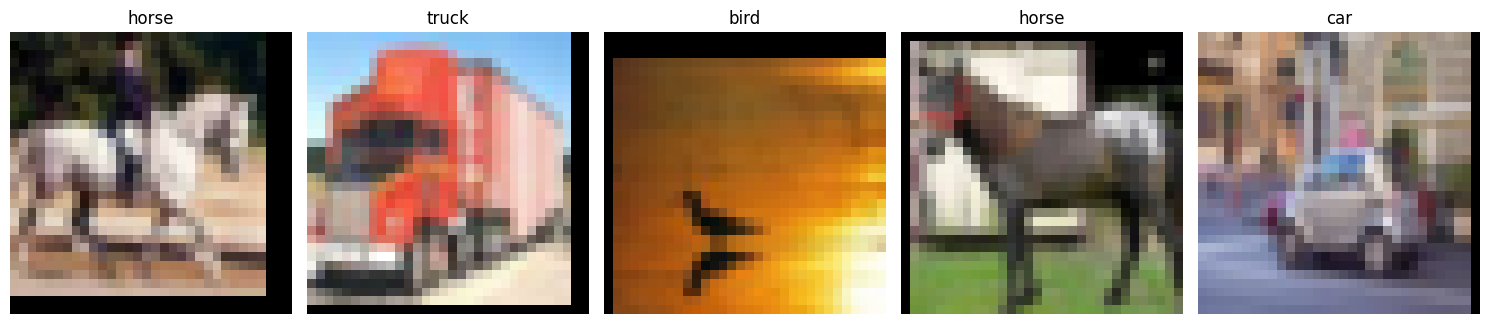

Showing 5 sample images from dataset

----------------------------------------
Training customcnn on cifar10
----------------------------------------
Model: customcnn
Number of parameters: 33482
Epoch 1/5
----------


train - Epoch 1/5:   0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 1.8959 Acc: 0.2932


test - Epoch 1/5:   0%|          | 0/79 [00:00<?, ?it/s]

test Loss: 1.7045 Acc: 0.3610

Epoch 2/5
----------


train - Epoch 2/5:   0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 1.6877 Acc: 0.3667


test - Epoch 2/5:   0%|          | 0/79 [00:00<?, ?it/s]

test Loss: 1.5985 Acc: 0.4087

Epoch 3/5
----------


train - Epoch 3/5:   0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 1.6106 Acc: 0.4057


test - Epoch 3/5:   0%|          | 0/79 [00:00<?, ?it/s]

test Loss: 1.5080 Acc: 0.4490

Epoch 4/5
----------


train - Epoch 4/5:   0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 1.5373 Acc: 0.4376


test - Epoch 4/5:   0%|          | 0/79 [00:00<?, ?it/s]

test Loss: 1.4617 Acc: 0.4640

Epoch 5/5
----------


train - Epoch 5/5:   0%|          | 0/391 [00:00<?, ?it/s]

train Loss: 1.4786 Acc: 0.4612


test - Epoch 5/5:   0%|          | 0/79 [00:00<?, ?it/s]

test Loss: 1.4368 Acc: 0.4803

Training complete in 3m 31s
Best test Acc: 0.4803


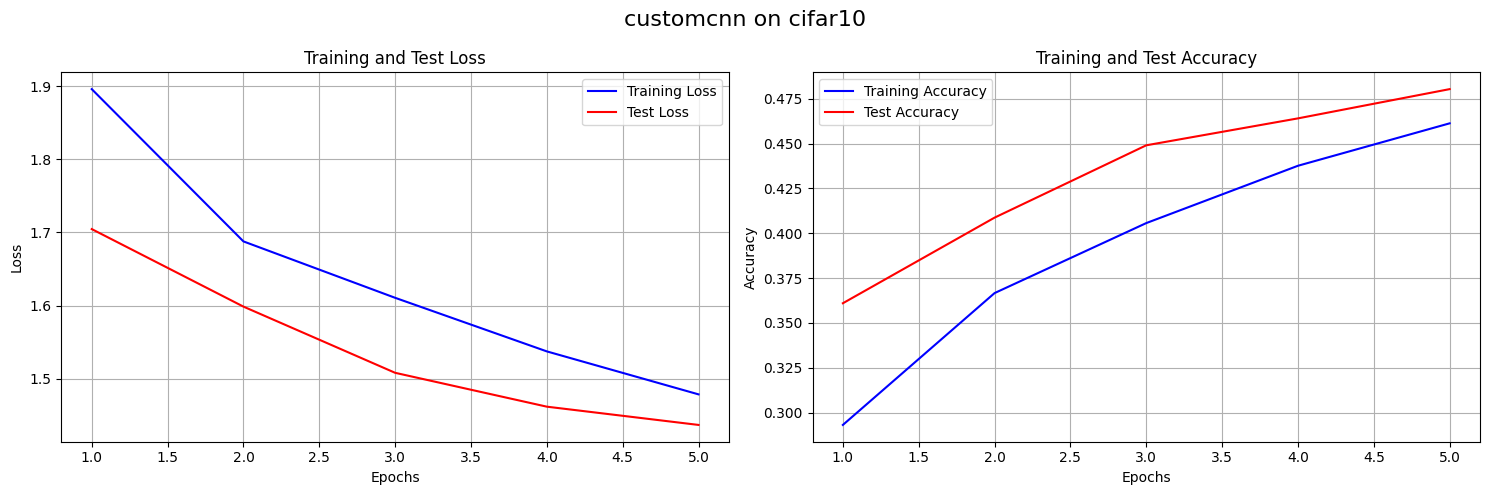

Training history plot saved to ./results/customcnn_on_cifar10_history.png


Evaluating on cifar10:   0%|          | 0/79 [00:00<?, ?it/s]

Test Loss: 1.4368 Acc: 0.4803


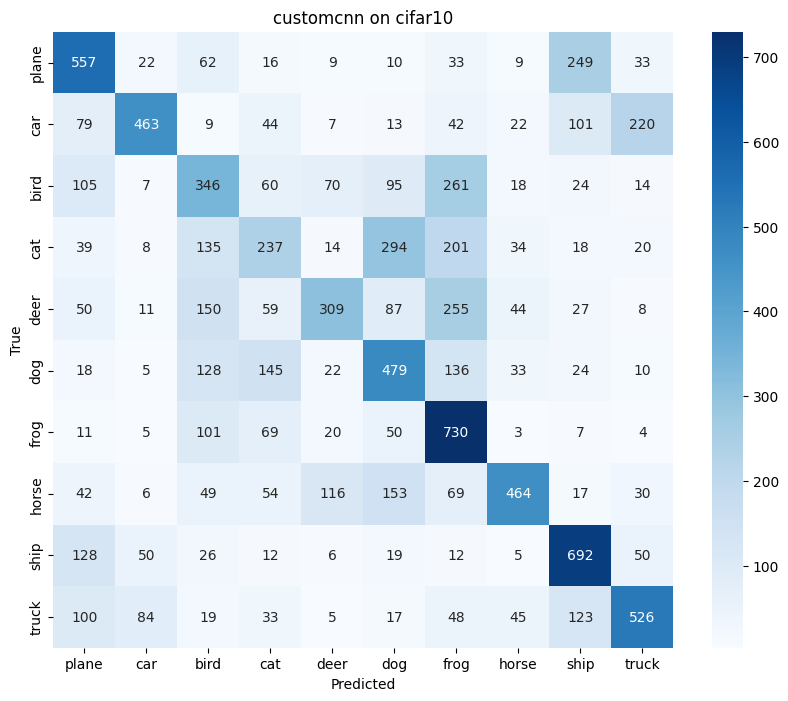

Confusion matrix plot saved to ./results/customcnn_on_cifar10_confusion_matrix.png
Classification report saved to ./results/customcnn_on_cifar10_classification_report.csv

Classification Report:


,precision,recall,f1-score,support
plane,0.493357,0.5570,0.523250,1000.0000
car,0.700454,0.4630,0.557495,1000.0000
bird,0.337561,0.3460,0.341728,1000.0000
cat,0.325103,0.2370,0.274147,1000.0000
deer,0.534602,0.3090,0.391635,1000.0000
dog,0.393591,0.4790,0.432115,1000.0000
frog,0.408506,0.7300,0.523861,1000.0000
horse,0.685377,0.4640,0.553369,1000.0000
ship,0.539782,0.6920,0.606486,1000.0000
truck,0.574863,0.5260,0.549347,1000.0000


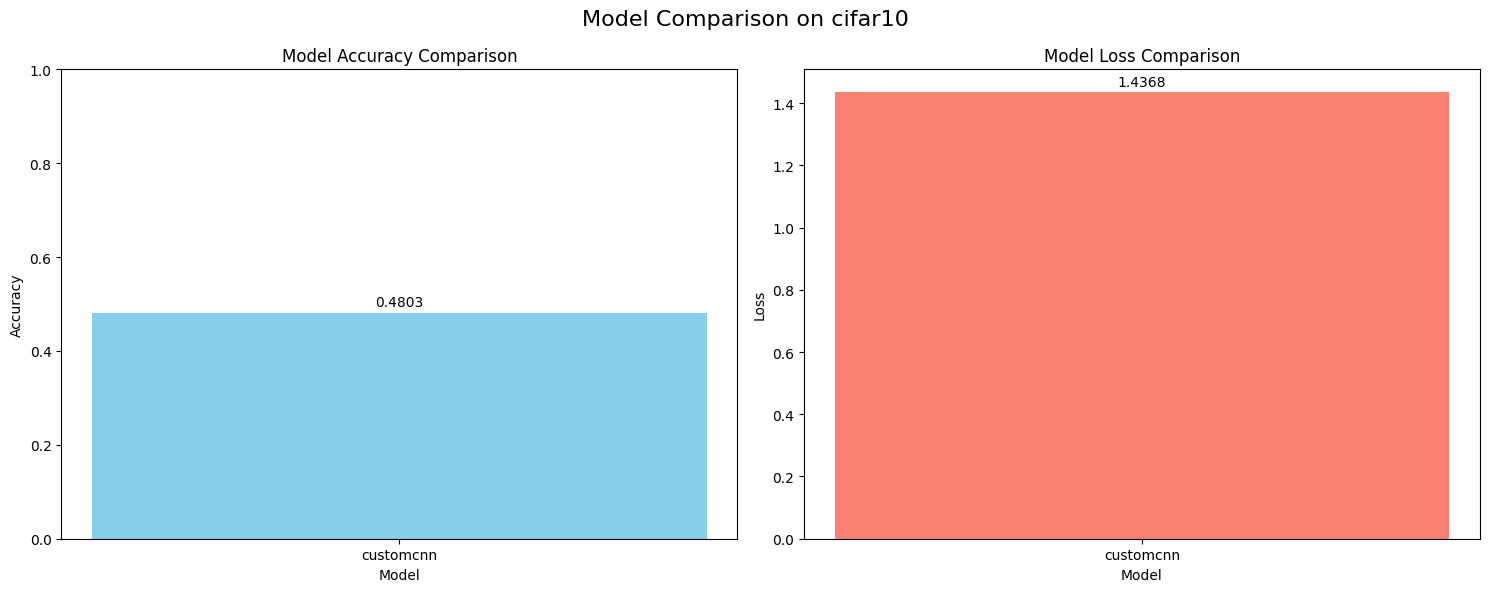

Model comparison plot saved to ./results/Model_Comparison_on_cifar10_comparison.png

Processing dataset: svhn
Dataset: SVHN
Number of training samples: 73257
Number of testing samples: 26032


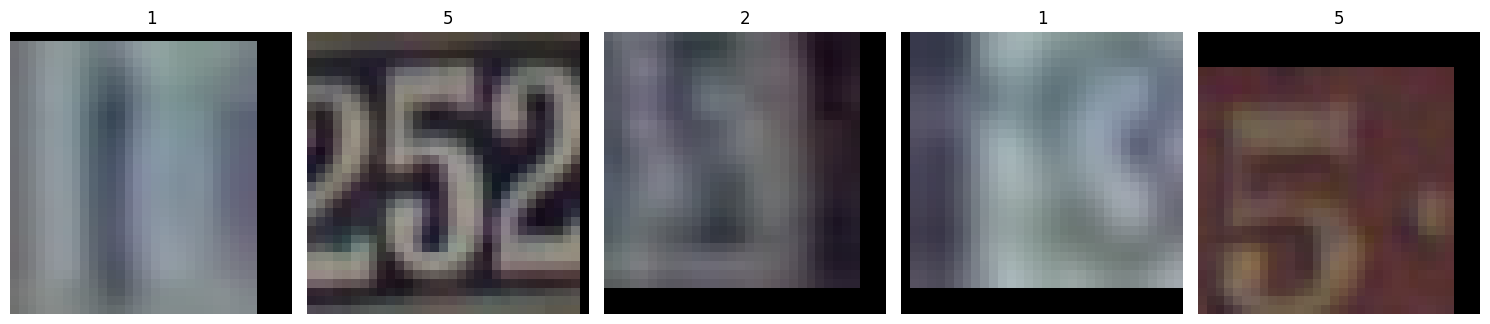

Showing 5 sample images from dataset

----------------------------------------
Training customcnn on svhn
----------------------------------------
Model: customcnn
Number of parameters: 33482
Epoch 1/5
----------


train - Epoch 1/5:   0%|          | 0/573 [00:00<?, ?it/s]

train Loss: 2.1701 Acc: 0.2265


test - Epoch 1/5:   0%|          | 0/204 [00:00<?, ?it/s]

test Loss: 2.0070 Acc: 0.3011

Epoch 2/5
----------


train - Epoch 2/5:   0%|          | 0/573 [00:00<?, ?it/s]

train Loss: 1.9484 Acc: 0.3064


test - Epoch 2/5:   0%|          | 0/204 [00:00<?, ?it/s]

test Loss: 1.8432 Acc: 0.3465

Epoch 3/5
----------


train - Epoch 3/5:   0%|          | 0/573 [00:00<?, ?it/s]

train Loss: 1.7779 Acc: 0.3709


test - Epoch 3/5:   0%|          | 0/204 [00:00<?, ?it/s]

test Loss: 1.6805 Acc: 0.4049

Epoch 4/5
----------


train - Epoch 4/5:   0%|          | 0/573 [00:00<?, ?it/s]

train Loss: 1.6186 Acc: 0.4408


test - Epoch 4/5:   0%|          | 0/204 [00:00<?, ?it/s]

test Loss: 1.5236 Acc: 0.4653

Epoch 5/5
----------


train - Epoch 5/5:   0%|          | 0/573 [00:00<?, ?it/s]

train Loss: 1.4993 Acc: 0.4930


test - Epoch 5/5:   0%|          | 0/204 [00:00<?, ?it/s]

test Loss: 1.4045 Acc: 0.5259

Training complete in 4m 29s
Best test Acc: 0.5259


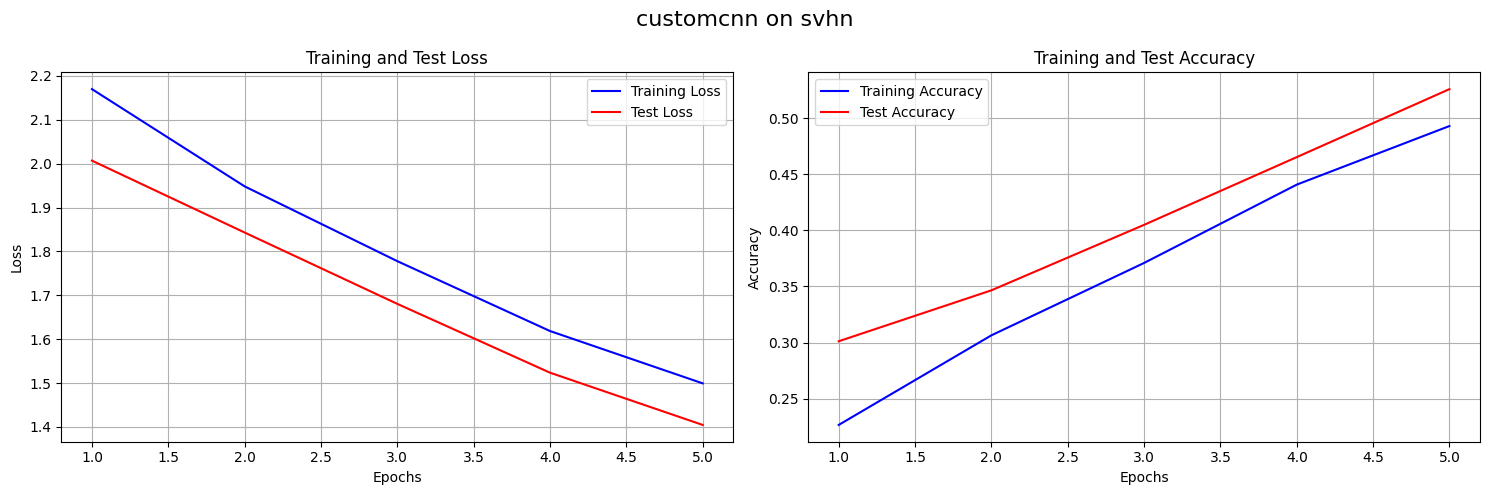

Training history plot saved to ./results/customcnn_on_svhn_history.png


Evaluating on svhn:   0%|          | 0/204 [00:00<?, ?it/s]

Test Loss: 1.4045 Acc: 0.5259


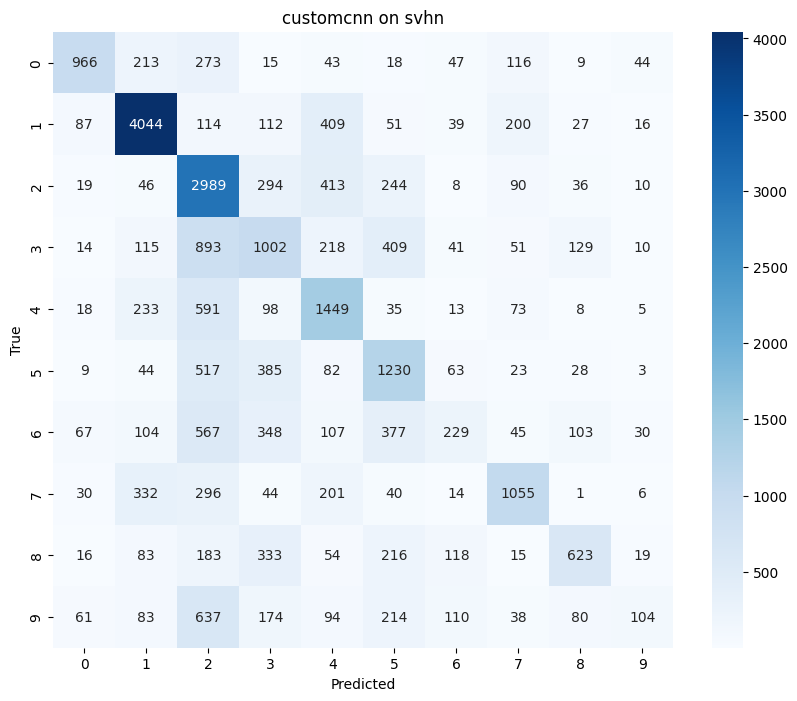

Confusion matrix plot saved to ./results/customcnn_on_svhn_confusion_matrix.png
Classification report saved to ./results/customcnn_on_svhn_classification_report.csv

Classification Report:


,precision,recall,f1-score,support
0,0.750583,0.553899,0.637413,1744.00000
1,0.763451,0.793097,0.777992,5099.00000
2,0.423371,0.720415,0.533321,4149.00000
3,0.357219,0.347675,0.352383,2882.00000
4,0.471987,0.574316,0.518148,2523.00000
5,0.434016,0.515940,0.471445,2384.00000
6,0.335777,0.115832,0.172245,1977.00000
7,0.618406,0.522536,0.566443,2019.00000
8,0.596743,0.375301,0.460799,1660.00000
9,0.421053,0.065204,0.112921,1595.00000


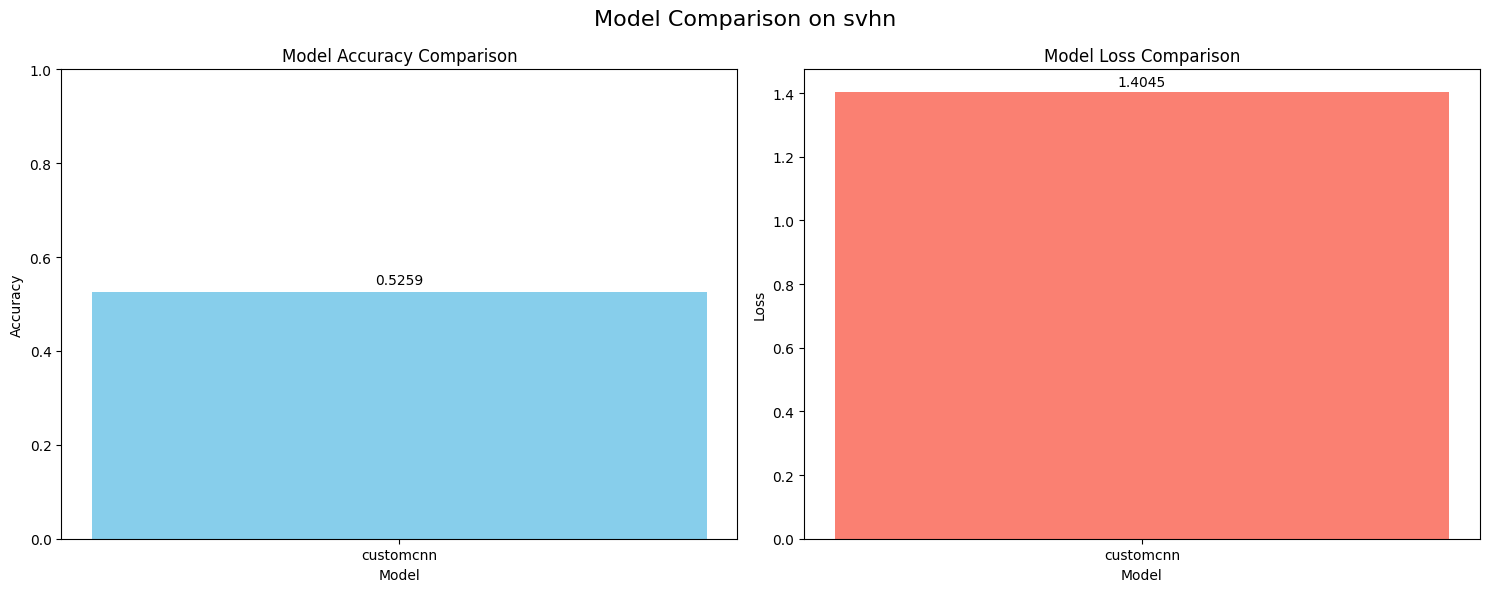

Model comparison plot saved to ./results/Model_Comparison_on_svhn_comparison.png

Final Results:

Dataset: cifar10
  customcnn: Accuracy = 0.4803, Loss = 1.4368

Dataset: svhn
  customcnn: Accuracy = 0.5259, Loss = 1.4045


In [17]:
def run_experiment(dataset_names=['cifar10', 'svhn'], 
                  model_names=#['lenet', 'resnet18', 
                   ['customcnn'],
                  customcnn_config=None,
                  batch_size=256, epochs=5, learning_rate=0.001, weight_decay=1e-4,
                  num_workers=2, save_dir='./results', log_step=100):
    """
    Run the complete experiment pipeline.
    """
    # Results dictionary to store metrics for all models and datasets
    results = defaultdict(dict)
    
    # Iterate over datasets
    for dataset_name in dataset_names:
        print(f"\n{'='*50}")
        print(f"Processing dataset: {dataset_name}")
        print(f"{'='*50}")
        
        # Load dataset (without validation set)
        train_loader, test_loader, dataset_info = get_datasets(
            dataset_name, batch_size=batch_size, num_workers=num_workers
        )
        
        # Visualize samples from the dataset
        visualize_dataset_samples(train_loader, dataset_info['classes'])
        
        # Iterate over models
        for model_name in model_names:
            print(f"\n{'-'*40}")
            print(f"Training {model_name} on {dataset_name}")
            print(f"{'-'*40}")
            
            # Initialize model (with custom config if customcnn)
            if model_name.lower() == 'customcnn':
                model = get_model(model_name, customcnn_config, 
                                  num_classes=dataset_info['num_classes'],
                                  input_channels=dataset_info['input_channels'])
            else:
                model = get_model(model_name, None,
                                  num_classes=dataset_info['num_classes'],
                                  input_channels=dataset_info['input_channels'])
            model = model.to(device)
            
            # Print model summary
            print(f"Model: {model_name}")
            print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")
            
            # Define loss function and optimizer
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
            
            # Learning rate scheduler
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
            
            # Train model
            model, history = train_model(
                model, train_loader, test_loader, criterion, optimizer, device,
                num_epochs=epochs, model_name=model_name, dataset_name=dataset_name,
                scheduler=scheduler, log_step=log_step, save_dir=save_dir
            )
            
            # Plot training history
            plot_training_history(
                history, f"{model_name} on {dataset_name}", save_dir=save_dir
            )
            
            # Evaluate model on test set
            test_loss, test_acc, test_preds, test_labels = evaluate_model(
                model, test_loader, criterion, device, dataset_name=dataset_name
            )
            
            # Store results
            results[dataset_name][model_name] = {
                'accuracy': test_acc,
                'loss': test_loss
            }
            
            # Plot confusion matrix
            plot_confusion_matrix(
                test_labels, test_preds, dataset_info['classes'],
                f"{model_name} on {dataset_name}", save_dir=save_dir
            )
            
            # Generate classification report
            report_df = generate_classification_report(
                test_labels, test_preds, dataset_info['classes'],
                f"{model_name} on {dataset_name}", save_dir=save_dir
            )
            
            print("\nClassification Report:")
            display(report_df)
            
        # Compare models for each dataset
        compare_models(
            results[dataset_name], f"Model Comparison on {dataset_name}", save_dir=save_dir
        )
    
    # Print final results
    print("\nFinal Results:")
    for dataset_name in dataset_names:
        print(f"\nDataset: {dataset_name}")
        for model_name in model_names:
            print(f"  {model_name}: Accuracy = {results[dataset_name][model_name]['accuracy']:.4f}, "
                  f"Loss = {results[dataset_name][model_name]['loss']:.4f}")
    
    return results

customcnn_config = {
    'filters': (32, 64, 128),       # Number of filters in each conv layer
    'kernel_sizes': (5, 5, 5),      # Kernel sizes for each conv layer (larger kernels)
    'fc_sizes': (512,),             # Larger fully connected layer
    'pool_type': 'max',             # Max pooling
    'dropout_rate': 0.1,            # Low dropout during training
    'use_batch_norm': True,         # Use batch normalization
    'activation': 'relu'            # ReLU activation
}

# Customize experiment parameters
experiment_params = {
    'dataset_names': ['cifar10', 'svhn'],                  # Datasets to use
    'model_names': ['customcnn'],      # Models to train
    'customcnn_config': customcnn_config,                   # Custom CNN config
    'batch_size': 128,                                      # Batch size
    'epochs': 5,                                           # Number of epochs
    'learning_rate': 0.001,                                 # Learning rate
    'weight_decay': 1e-5,                                  # Weight decay (reduced to help training acc)
    'num_workers': 2                                        # CPU threads for data loading
}    

results = run_experiment(**experiment_params)

## Evaluating Trained Models

In [18]:
def evaluate_trained_model(model_name, dataset_name, checkpoint_path, customcnn_config=None):
    """
    Evaluate a trained model on test data.
    """
    # Load dataset (without validation)
    train_loader, test_loader, dataset_info = get_datasets(
        dataset_name, batch_size=128, num_workers=2
    )
    
    # Initialize model
    if model_name.lower() == 'customcnn' and customcnn_config is not None:
        model = get_model(
            model_name, customcnn_config,
            num_classes=dataset_info['num_classes'],
            input_channels=dataset_info['input_channels']
        )
    else:
        model = get_model(
            model_name, None,
            num_classes=dataset_info['num_classes'],
            input_channels=dataset_info['input_channels']
        )
    model = model.to(device)
    
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)
    if 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint)
    
    # Define loss function
    criterion = nn.CrossEntropyLoss()
    
    # Evaluate model on test set
    test_loss, test_acc, test_preds, test_labels = evaluate_model(
        model, test_loader, criterion, device, dataset_name=dataset_name
    )
    
    # Plot confusion matrix
    plot_confusion_matrix(
        test_labels, test_preds, dataset_info['classes'],
        f"{model_name} on {dataset_name} Test Set", save_dir='./results'
    )
    
    # Generate classification report
    report_df = generate_classification_report(
        test_labels, test_preds, dataset_info['classes'],
        f"{model_name} on {dataset_name} Test Set", save_dir='./results'
    )
    
    print("\nClassification Report:")
    display(report_df)
    
    return test_acc, test_loss